# This Notebook is an example of using pcap pandas analytics to build a graph from Ian Taylor's Newt orchestration of Hamlet

In [21]:
import IPython
import matplotlib
from distutils.version import StrictVersion
ipy4 = False
violin = False
if StrictVersion(IPython.__version__) >= StrictVersion("4.0"):
    ipy4 = True
if StrictVersion(matplotlib.__version__) >= StrictVersion("1.5"):
    violin = True
    
import log2pd as lpd
#import plotpd as ppd
import pandas as pd
import log2plot as l2plot
import analystPlots as appd
import logAnalyticsLib as lalib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import numpy as np
import os
import warnings
from netaddr import IPNetwork
import glob
from StringIO import StringIO
import fileinput
from pandas.lib import Timestamp
import datetime
import subprocess
#from IPython.display import Image
#os.system("taskset -p 0xFFFFFFFF %d" % os.getpid())
# Setup some plot defaults for the duration of this notebook
#ppd.setup_plot_defaults()
warnings.filterwarnings("ignore")
root_dir = '.'
%matplotlib inline

In [22]:
#df = lalib.load_hdf5('./store-mgen-mcast-ham.hdf5')  
from scipy.interpolate import interp1d
from operator import itemgetter

In [23]:
# Read the node file and create a dict of ip address to CORE nodename
n_to_a_dict={}
import csv
with open('./node_info.node', 'rb') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ')
    for row in reader:
        n_to_a_dict[row[2]]=row[0]
print n_to_a_dict
#n_to_a_dict['224.0.5.2']='n50'
#
# Use CORE names for graph nodes

import networkx as nx
G=nx.DiGraph()
nodes = n_to_a_dict.values()
G.add_nodes_from(nodes)
n_weights={node:0 for node in nodes}
print n_weights
nx.set_node_attributes(G,'weight',n_weights)
print G.nodes(data=True)

{'10.0.0.33': 'n33', '10.0.0.32': 'n32', '10.0.0.31': 'n31', '10.0.0.30': 'n30', '10.0.0.35': 'n35', '10.0.0.34': 'n34', '10.0.0.15': 'n15', '10.0.0.14': 'n14', '10.0.0.17': 'n17', '10.0.0.16': 'n16', '10.0.0.11': 'n11', '10.0.0.10': 'n10', '10.0.0.13': 'n13', '10.0.0.12': 'n12', '10.0.0.19': 'n19', '10.0.0.18': 'n18', '10.0.0.9': 'n9', '10.0.0.8': 'n8', '10.0.0.5': 'n5', '10.0.0.4': 'n4', '10.0.0.7': 'n7', '10.0.0.6': 'n6', '10.0.0.1': 'n1', '10.0.0.3': 'n3', '10.0.0.2': 'n2', '10.0.0.28': 'n28', '10.0.0.29': 'n29', '10.0.0.24': 'n24', '10.0.0.25': 'n25', '10.0.0.26': 'n26', '10.0.0.27': 'n27', '10.0.0.20': 'n20', '10.0.0.21': 'n21', '10.0.0.22': 'n22', '10.0.0.23': 'n23'}
{'n12': 0, 'n13': 0, 'n10': 0, 'n11': 0, 'n16': 0, 'n17': 0, 'n14': 0, 'n15': 0, 'n18': 0, 'n19': 0, 'n30': 0, 'n31': 0, 'n32': 0, 'n33': 0, 'n34': 0, 'n35': 0, 'n29': 0, 'n28': 0, 'n23': 0, 'n22': 0, 'n21': 0, 'n20': 0, 'n27': 0, 'n26': 0, 'n25': 0, 'n24': 0, 'n8': 0, 'n9': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n

In [25]:
#Must first run newt based hamlet.sh to get DataCollect directory
mcastpd=lpd.load_pcap_data("./results/Collect_ActISceneII/",duplicates=True,timeseries=True,dataSet=True)

log2pd::process_chunk exception: Cannot set a frame with no defined index and a value that cannot be converted to a Series!!
log2pd::process_chunk exception: Cannot set a frame with no defined index and a value that cannot be converted to a Series!!
log2pd::process_chunk exception: Cannot set a frame with no defined index and a value that cannot be converted to a Series!!
log2pd::process_chunk exception: Cannot set a frame with no defined index and a value that cannot be converted to a Series!!
log2pd:load_pcap_file_internal() no data in chunk
log2pd:load_pcap_file_internal() no data in chunk
log2pd:load_pcap_file_internal() no data in chunk
log2pd:load_pcap_file_internal() no data in chunk
log2pd::process_chunk exception: Cannot set a frame with no defined index and a value that cannot be converted to a Series!!log2pd::process_chunk exception: Cannot set a frame with no defined index and a value that cannot be converted to a Series!!log2pd::process_chunk exception: Cannot set a frame 

In [26]:
sorteddf=mcastpd.sort_index()

In [27]:
sorteddf=sorteddf[sorteddf["frameType"]=="UDP"]

In [28]:
sorteddf[:1]

,time,len,ipSrc,ipDst,proto,ipttl,frameType,ethSrc,ethDst,mcast,...,nodeName,iface,mac,ipSrcPort,ipDstPort,trafficType,ipSrcNum,ipDstNum,dir,frameProtocol
1,2016-04-27 21:40:19.409440,1803,10.0.0.4,10.0.0.7,UDP,64,UDP,00:00:00:aa:00:03,00:00:00:aa:00:0c,0,...,n4,eth0,00:00:00:aa:00:03,6000.0,6001.0,1,167772164,167772167,1,UDP


In [29]:
###### Build and estimated  CAG from adjacencies
last_speaker=None
# Build a graph from multicast packets received
# Use ipSrc information to create pair-wise adjacencies
for index,row in sorteddf.iterrows():
    if last_speaker == None:
        last_speaker = row.ipSrc
    elif last_speaker == row.ipSrc:
        pass
    else:
        G.node[n_to_a_dict[row.ipSrc]]["weight"] += 1
        if G.has_edge(n_to_a_dict[last_speaker],n_to_a_dict[row.ipSrc]):
            G[n_to_a_dict[last_speaker]][n_to_a_dict[row.ipSrc]]['weight'] += 1
        else:
            G.add_edge(n_to_a_dict[last_speaker],n_to_a_dict[row.ipSrc],weight= 1)
        last_speaker= row.ipSrc
#G.remove_node('n50')

In [30]:
print G.edges(data=True)

[('n13', 'n4', {'weight': 2}), ('n13', 'n16', {'weight': 6}), ('n16', 'n13', {'weight': 7}), ('n16', 'n17', {'weight': 95}), ('n16', 'n18', {'weight': 1}), ('n16', 'n21', {'weight': 17}), ('n16', 'n4', {'weight': 5}), ('n16', 'n2', {'weight': 3}), ('n17', 'n4', {'weight': 1}), ('n17', 'n21', {'weight': 10}), ('n17', 'n16', {'weight': 93}), ('n17', 'n2', {'weight': 2}), ('n18', 'n16', {'weight': 1}), ('n18', 'n4', {'weight': 2}), ('n28', 'n16', {'weight': 1}), ('n28', 'n4', {'weight': 2}), ('n21', 'n2', {'weight': 2}), ('n21', 'n16', {'weight': 16}), ('n21', 'n17', {'weight': 9}), ('n2', 'n4', {'weight': 3}), ('n2', 'n16', {'weight': 3}), ('n2', 'n17', {'weight': 2}), ('n4', 'n13', {'weight': 1}), ('n4', 'n16', {'weight': 8}), ('n4', 'n18', {'weight': 2}), ('n4', 'n28', {'weight': 3}), ('n4', 'n2', {'weight': 1}), ('n4', 'n7', {'weight': 3}), ('n7', 'n4', {'weight': 3})]


In [31]:
def plot_anal_graph(G,maxsize=1000,alpha=0.3,font_size=14,
                    plot_type=1,maxedge=1,pos=None):
    from scipy.interpolate import interp1d
    if plot_type == 1:
        node_weights = nx.get_node_attributes(G,"weight")
        edge_weights = nx.get_edge_attributes(G,"weight")
        title = "Nodes Dialogue Events, Edges Causality Events"
    else:        
        node_weights = nx.in_degree_centrality(G)
        edge_weights = nx.edge_betweenness_centrality(G,weight="cost",normalized=True)
        title = "Nodes Current Centrality, Edges Betweenness Centrality"
    ncolors=[]
    # Dictionaries are not ordered properly so make sure it ordered with nodes
    for node in G.nodes():
        ncolors.append(node_weights[node])
    ecolors=[]
    for edge in G.edges():
        ecolors.append(edge_weights[edge])

    mn = interp1d([0,1],[100,maxsize])
    me = interp1d([0,1],[0,maxedge])
    dn = interp1d([min(ncolors),max(ncolors)],[0,1]) 
    de = interp1d([min(ecolors),max(ecolors)],[0,1])
    ncolors = dn(ncolors) 
    nsizes =  mn(ncolors)
    ecolors = de(ecolors) 
    esizes =  me(ecolors)

    plt.axis('off')
    plt.title(title, size=24)
    if pos is None:
        pos=nx.spring_layout(G,k=1,iterations=100,weight='weight')
    else:
        pos=pos
    nx.draw_networkx_nodes(G,pos,node_color=ncolors,\
                           node_size=nsizes,alpha=alpha,cmap=cmx.jet)
    nx.draw_networkx_labels(G,pos,font_size=font_size)
    nx.draw_networkx_edges(G,pos,edge_color=ecolors,\
                           width=esizes,alpha=alpha)

In [32]:
def plot_ordered_items(dict_weights, title=None):
    order_items = sorted(dict_weights.iteritems(), key=itemgetter(1), reverse=True)
    #reverse zip tuples in to separate lists
    order_items = zip(*order_items)
    my_xticks = order_items[0]
    x = [i for i in range(0,len(my_xticks))]
    offset = [i+0.5 for i in x]
    fig = plt.Figure(figsize=(20,14))
    plt.xticks(offset, my_xticks,rotation=90)
    plt.bar(x,order_items[1],alpha=0.3)
    if title != None:
        plt.title(title)
    plt.show()

In [33]:
node_to_actor={
'n1':'Ambassador',
'n2':'Bernardo',
'n3':'Captain',
'n4':'Claudius',
'n5':'Clown1',
'n6':'Clown2',
'n7':'Cornelius',
'n8':'Danes',
'n9':'Horatio',
'n10':'Fortinbras',
'n11':'Francisco',
'n12':'Gentleman',
'n13':'Gertrude',
'n14':'Ghost',
'n15':'Guildenstern',
'n16':'Hamlet',
'n17':'Horatio',
'n18':'Laertes',
'n19':'Lord',
'n20':'Lucianus',
'n21':'Marcellus',
'n22':'Messenger',
'n23':'Ophelia',
'n24':'Osric',
'n25':'Player1',
'n26':'Player_King',
'n27':'Player_Queen',
'n28':'Polonius',
'n29':'Priest',
'n30':'Prologue',
'n31':'Reynaldo',
'n32':'Rosencrantz',
'n33':'Sailor',
'n34':'Servant',
'n35':'Voltimand'
}


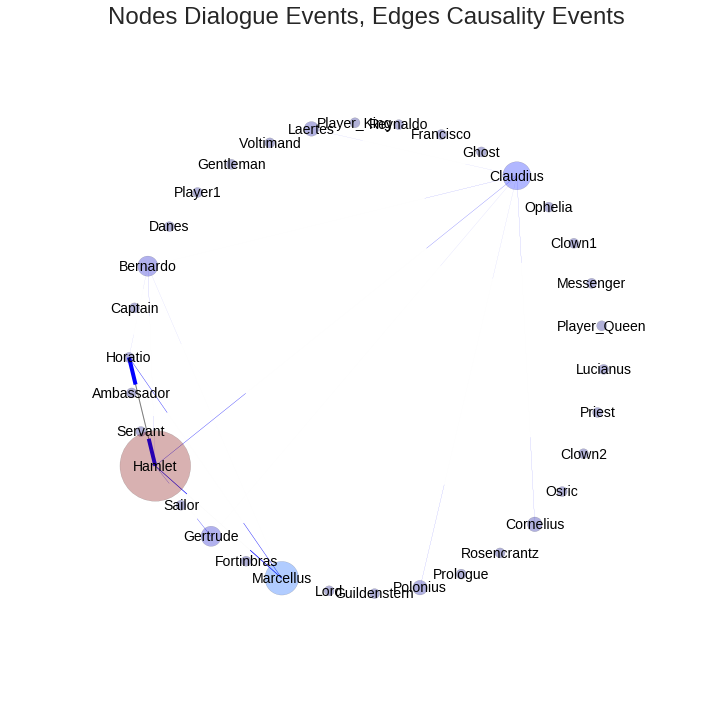

In [34]:
G=nx.relabel_nodes(G,node_to_actor)
Figure=plt.figure(figsize=(10,10))
pos=nx.spring_layout(G,k=1,iterations=100,weight='weight')
plot_anal_graph(G,maxsize=5000,maxedge=1,alpha=0.3,pos=pos)

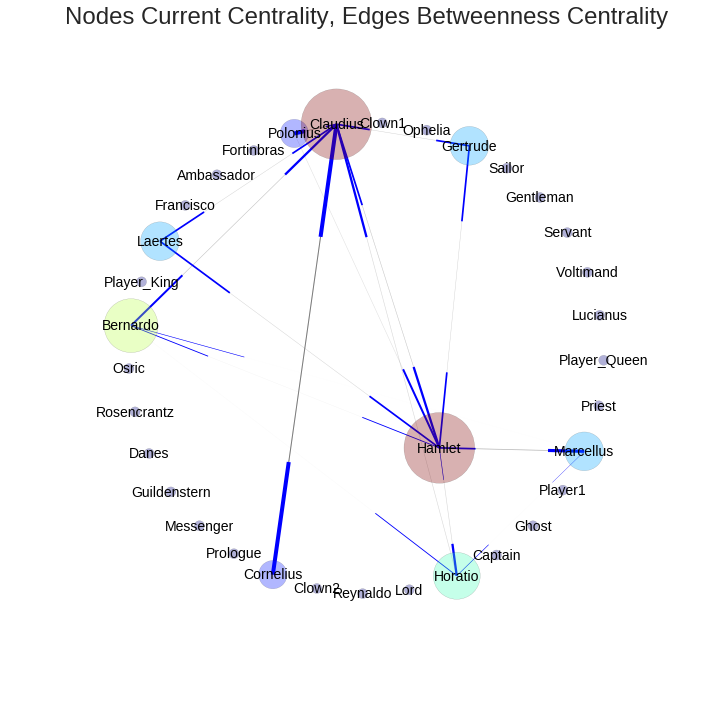

In [35]:
pos=nx.spring_layout(G,k=1,iterations=1000)
Figure = plt.figure(figsize=(10,10))
plot_anal_graph(G,maxsize=5000,maxedge=1,plot_type=2,alpha=0.3,pos=pos)

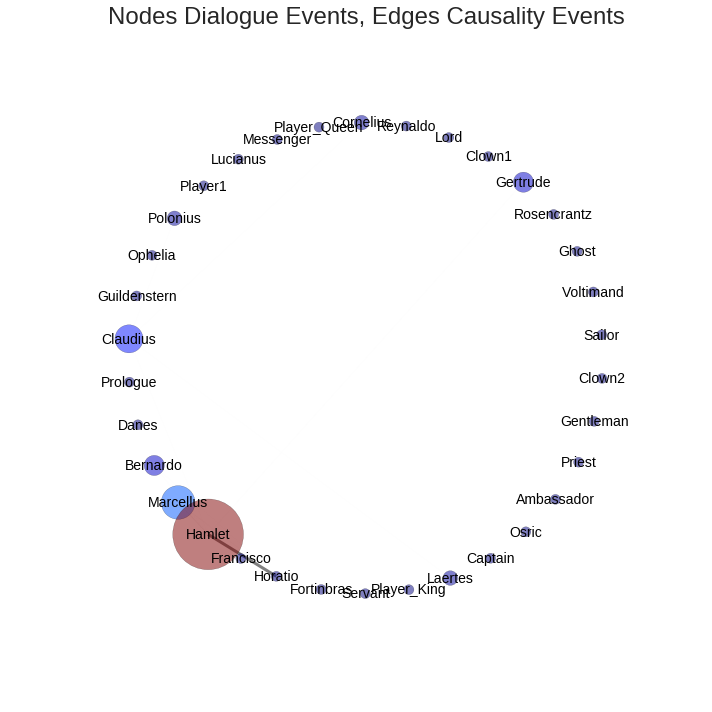

In [36]:
Gu=G.to_undirected(reciprocal=True)
Figure = plt.figure(figsize=(10,10))
pos=nx.spring_layout(Gu,k=1,iterations=100)
plot_anal_graph(Gu,maxsize=5000,maxedge=3,alpha=0.5,pos=pos)

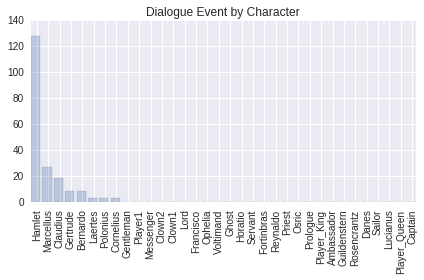

In [37]:
node_weights = nx.get_node_attributes(G,"weight")
plot_ordered_items(node_weights,title="Dialogue Event by Character")

NetworkXError: Node 'Rosencrantz' has no position.

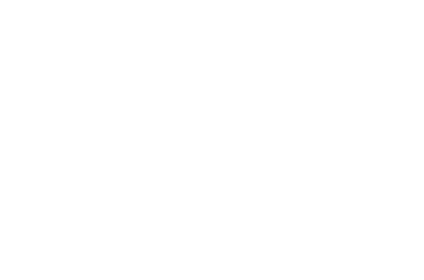

In [18]:
Gu=G

# Experiment with a Ring Layout of Actors in graphs
ring1 = ['Hamlet']
ring2 = ['Horatio','Polonius','Claudius','Ophelia','Gertrude','Laertes','Rosencranz']
ring3 = ['Marcellus','Ghost','Bernardo','Francisco','Guildenstern']
outer = ['Voltimand','Cornelius','Osric','Reynaldo','Fortinbras',\
        'Player1','Clown1','Clown2','Captain','Servant','Gentleman',\
         'Danes','Player_Queen','Player_King','Priest','Prologue',\
         'Lucianus','Ambassador','Messenger','Lord','Sailor']
maxsize=3000
maxedge=2
node_weights = nx.get_node_attributes(Gu,"weight")
edge_weights = nx.get_edge_attributes(Gu,"weight")
ncolors=[]
    # Dictionaries are not ordered properly so make sure it ordered with nodes
for node in Gu.nodes():
    ncolors.append(node_weights[node])
ecolors=[]
for edge in Gu.edges():
    ecolors.append(edge_weights[edge])

mn = interp1d([0,1],[100,maxsize])
me = interp1d([0,1],[0,maxedge])
dn = interp1d([min(ncolors),max(ncolors)],[0,1]) 
de = interp1d([min(ecolors),max(ecolors)],[0,1])
ncolors = dn(ncolors) 
nsizes =  mn(ncolors)
ecolors = de(ecolors) 
esizes =  me(ecolors)
nlist = [ring1,ring2,ring3,outer]
plt.axis('off')

pos=nx.shell_layout(Gu, nlist=nlist, dim=3, scale=5)
nx.draw_networkx_nodes(Gu,pos,node_color=ncolors,\
                       node_size=nsizes,alpha=0.3,cmap=plt.cm.jet)
nx.draw_networkx_labels(Gu,pos,font_size=14,cmap=plt.cm.jet)
nx.draw_networkx_edges(Gu,pos,edge_color=ecolors,\
                       width=esizes,alpha=0.5,cmap=plt.cm.jet)

(0, 12)

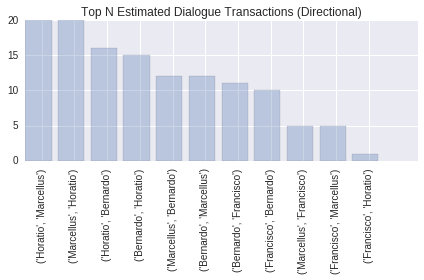

In [19]:
edge_weights = nx.get_edge_attributes(G,"weight")
order_edges = sorted(edge_weights.iteritems(), key=itemgetter(1), reverse=True)
#reverse zip tuples in to separate lists
order_edges = zip(*order_edges)
my_xticks = order_edges[0]
x = [i for i in range(0,len(my_xticks))]
offset = [i+0.5 for i in x]
fig = plt.Figure(figsize=(30,15))
plt.xticks(offset, my_xticks,rotation=90)
plt.bar(x,order_edges[1],alpha=0.3)
plt.title('Top N Estimated Dialogue Transactions (Directional)')
plt.xlim(0,12)

In [20]:
#Make json file for d3.js arc diagram
import json
#for source,target,info in G.edges_iter(data=True):
#    print source,target,info

In [23]:
# Put this in format arc js expects
js_graph={}
nodelist=[node for node in G.nodes()]


js_graph["nodes"]=[{"value":node} for node,data in G.nodes(data=True)]
js_graph["links"]=[{"source":nodelist.index(source),\
                    "target":nodelist.index(target), \
                    "weight":info["weight"]} \
                   for source,target,info in G.edges_iter(data=True)]
with open('graph.json', 'w') as outfile:
    json.dump(js_graph, outfile)


In [24]:
with open('graph.json', 'r') as handle:
    parsed = json.load(handle)
#print json.dumps(parsed, indent=4, sort_keys=True)